# Import

In [1]:
import numpy as np
import h5py
import copy
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

import requests
from io import BytesIO

# Helper Functions

In [2]:
# Load the data from the .h5 file containing the images and the labels 
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
# sigmoid is the activation function used in this binary classificaction
def sigmoid(z):

    s = 1 / (1 + np.exp(-z))
    
    return s

In [4]:
# Helper function to initialize w and b to zeros. 
def initialize_with_zeros(dim):
    
    w = np.zeros((dim,1))
    b = float(0)
    return w, b

# Analysing the data 

 Let's load the data into our variables and look at what they are

In [5]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

 Each line of the train_set_x and test_set_x is an image with 64x64 pixels, with the label given by the train_set_y variable. <font>

y = 1, labeled as a cat picture.


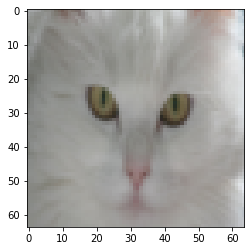

In [6]:
plt.imshow(train_set_x_orig[50])
print("y = " + str(train_set_y[0,50]) + ", labeled as a "  + classes[train_set_y[0,50]].decode("utf-8") + " picture." )

The dimensions of the training and test examples are

In [7]:
m_train = (train_set_x_orig.shape[0])
m_test  = (test_set_x_orig.shape[0])
num_px  = (test_set_x_orig.shape[1])

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


Now let's reshape the training and test sets as a flattened vector of shape (num_px * num_px * 3, 1) <font>

In [8]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T


print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))


train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


 So now the entire dataset is represented in a vector shape of (12288, 209). In order to standardize our datasets,
we divide the the train and test sets by 255, representing the maximum value of a pixel.

In [9]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255

# Implementing the algorithm

<a name='3'></a>
We build our algorithm using Logistic Regression, a simple Neural Network!

<img src="learning_scheme.png" style="width:650px;height:400px;">


In general terms, each image, translated in the flattened vector, is fed into our algorithm. The algorithm will compute the best parameters $w$ and $b$ and output a value of $\hat{y}$ between {0,1}. From $\hat{y}$ we then determine if it's a cat or not a cat.

**The mathematical expression of the algorithm are as follows**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

## Computing forward and backwards propagation

In the forward propagation the goal is to compute the activation function $\\$
$A = \sigma ( w^T X + b) $

and the cost function

$J = -\frac{1}{m}\sum_{i=1}^{m}(y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)}))$

In [10]:
def propagate(w, b, X, Y):
    """
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    """
    
    m = X.shape[1] # is the number of examples
    
    A = sigmoid(np.dot(w.T,X) + b)
    cost = -(1/m)*np.sum( np.dot(Y, np.log(A.T)) + np.dot((1-Y),(np.log(1-A.T))) )

    dw = (1/m)*np.dot(X,(A-Y).T)
    db = (1/m)*((A-Y)).sum()
    cost = np.squeeze(np.array(cost))
    
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

## Optimize function that will learn the parameters $w$ and $b$ that minimizes the cost function $J$

In [11]:
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    
    costs = []
    
    for i in range(num_iterations):

        grads, cost = propagate(w, b, X, Y)
                
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]

        w = w - learning_rate*dw
        b = b - learning_rate*db
                
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
            # Print the cost every 100 training iterations
        #if print_cost:
         #   print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

## Predict function that will use $w$ and $b$ optimized in the previous function to predict the labels for the dataset X

In [12]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1] # number of examples
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)  # dimensions w = (num_px * num_px * 3, 1)
                                  # dimensions X = (num_px * num_px * 3, number of examples)

    A = sigmoid(np.dot(w.T,X) + b)  # dimensions A = (1, number of examples)
    
        
    for i in range(A.shape[1]):
        
        if A[0, i] > 0.5 :
            Y_prediction[0,i] = 1
        else:
            Y_prediction[0,i] = 0
        
    
    return Y_prediction

# Merger Model with all the previous functions

In [13]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to True to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    # Initialize w and b learning parameters
    w, b = initialize_with_zeros(X_train.shape[0])
    
    # Optimize function that will learn the best parameters w and b
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
     
    # Obtain the best parameters w and b
    w = params["w"]
    b = params["b"]
    
    # Obtain the predictions
    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)

    # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [14]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=10000, learning_rate=0.005, print_cost=True)

train accuracy: 100.0 %
test accuracy: 70.0 %


The training accuracy is 100%, as it should be, while the test accuracy is 70%, which is not bad given the small dataset we used.

As a next step, we could work on reducing the model overfitting on training data. 

Let's plot the cost function versus the iterations and check the convergence!

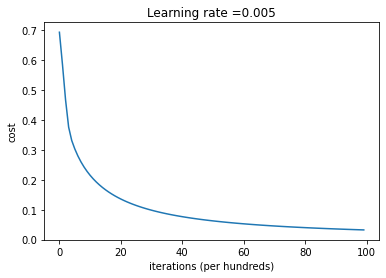

In [15]:
costs = np.squeeze( logistic_regression_model['costs'] )
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(logistic_regression_model["learning_rate"]))
plt.show()

# Learning rate dependence

Training a model with learning rate: 0.01

-------------------------------------------------------

Training a model with learning rate: 0.001

-------------------------------------------------------

Training a model with learning rate: 0.0001

-------------------------------------------------------



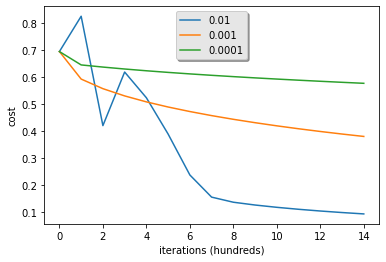

In [16]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}

for lr in learning_rates:
    print ("Training a model with learning rate: " + str(lr))
    models[str(lr)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=1500, learning_rate=lr, print_cost=False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for lr in learning_rates:
    plt.plot(np.squeeze(models[str(lr)]["costs"]), label=str(models[str(lr)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Interpretation**: 
- Different learning rates give different costs and thus different predictions results.
- If the learning rate is too large (0.01), the cost may oscillate up and down. It may even diverge (though in this example, using 0.01 still eventually ends up at a good value for the cost). 
- A lower cost doesn't mean a better model. You have to check if there is possibly overfitting. It happens when the training accuracy is a lot higher than the test accuracy.


# Testing with an online image

In [17]:

def is_cat(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    image_array = np.array(img.resize((num_px,num_px)))
    plt.imshow(image_array)

    #Normalize the image
    image_array = image_array / 255
    image_array = image_array.reshape(num_px*num_px*3, 1)

    output_prediction = predict( logistic_regression_model["w"], logistic_regression_model["b"], image_array)

    print("y = " + str(np.squeeze(output_prediction)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(output_prediction)),].decode("utf-8") +  "\" picture.")

y = 1.0, your algorithm predicts a "cat" picture.


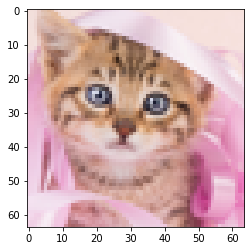

In [18]:
is_cat("https://i.imgur.com/jOAc2Le.png")

y = 1.0, your algorithm predicts a "cat" picture.


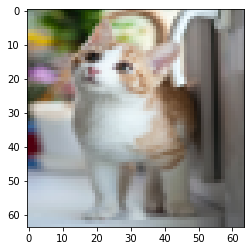

In [19]:
is_cat("https://i.imgur.com/CY6beLX.png")

y = 0.0, your algorithm predicts a "non-cat" picture.


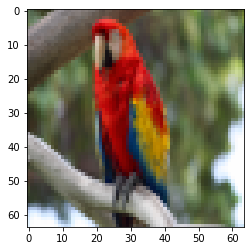

In [20]:
is_cat("https://i.imgur.com/bNrVeTx.png")

y = 0.0, your algorithm predicts a "non-cat" picture.


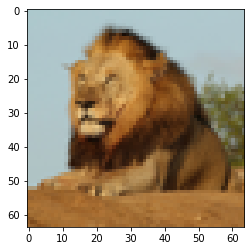

In [21]:
is_cat("https://i.imgur.com/UAooJ1a.png")